In [25]:
# --- Setup: Make repo importable ---
import sys
from pathlib import Path

REPO_ROOT = Path("..").resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))
print("repo root:", REPO_ROOT)


repo root: C:\Users\ruzgh\PycharmProjects\pixelart-ccgen


In [26]:
# --- Config ---
RUN_DOWNLOAD = True  # set False to skip download step
DATASET_SLUG = "ebrahimelgazar/pixel-art"  # Kaggle slug (owner/dataset)
RAW_DIR = Path("../data/raw")
CSV_PATH = RAW_DIR / "labels.csv"
CACHE_DIR = Path("../data/_cache")
OUT_INDEX = CACHE_DIR / "dataset_index.csv"
OUT_MAP = CACHE_DIR / "class_to_idx.json"

SAMPLES_PER_CLASS = 16
RANDOM_STATE = 0


In [27]:
# --- Imports ---
import re, json
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from src.data.fetch import download_datasets


In [28]:
# --- Download dataset if needed ---
RAW_DIR.mkdir(parents=True, exist_ok=True)
empty = (len(list(RAW_DIR.rglob('*'))) == 0)

if RUN_DOWNLOAD and empty:
    print("downloading:", DATASET_SLUG)
    download_datasets(DATASET_SLUG, out_dir=RAW_DIR)
else:
    print("skip download (RUN_DOWNLOAD=False or RAW not empty)")


skip download (RUN_DOWNLOAD=False or RAW not empty)


In [29]:
# --- Read labels ---
df = pd.read_csv(CSV_PATH).rename(columns={"Image Index": "id", "Label": "class_name"})
df["id"] = df["id"].astype(int)

# factorize classes
df["class_idx"], class_names = pd.factorize(df["class_name"], sort=True)
class_to_idx = {name: int(i) for i, name in enumerate(class_names)}
idx_to_class = {int(i): name for i, name in enumerate(class_names)}


In [30]:
# --- Match IDs to image files ---
pat = re.compile(r"image_(\d+)", re.IGNORECASE)
ALLOWED_EXT = {".png", ".jpg", ".jpeg", ".bmp", ".gif", ".webp"}

id2path = {
    int(m.group(1)): p
    for p in RAW_DIR.rglob("*")
    if p.suffix.lower() in ALLOWED_EXT and (m := pat.search(p.name))
}

def safe_resolve(p):
    if p is None:
        return None
    try:
        return str(Path(p).resolve())
    except Exception:
        return None

df["path"] = df["id"].map(id2path).apply(safe_resolve)

missing = df["path"].isna().sum()
if missing:
    print(f"warning: {missing} rows have no matching image file and will be dropped")

# drop rows without a valid file
df = df[df["path"].notna()].reset_index(drop=True)


In [31]:
# --- Save dataset index + class map ---
CACHE_DIR.mkdir(parents=True, exist_ok=True)

df[["id", "path", "class_idx", "class_name"]].to_csv(OUT_INDEX, index=False)
OUT_MAP.write_text(json.dumps({
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class
}, indent=2), encoding="utf-8")

print(f"rows: {len(df)} | classes: {df['class_idx'].nunique()}")
print("saved:", OUT_INDEX, "and", OUT_MAP)


rows: 89399 | classes: 5
saved: ..\data\_cache\dataset_index.csv and ..\data\_cache\class_to_idx.json


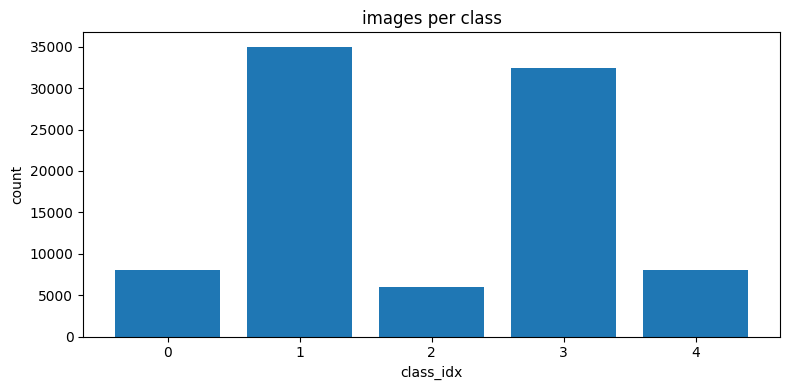

In [32]:
# --- Quick EDA: class counts ---
counts = df["class_idx"].value_counts().sort_index()
plt.figure(figsize=(8, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("images per class")
plt.xlabel("class_idx")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [33]:
# --- Show image grid (corrected colors & alpha handling) ---
def show_grid(paths, cols=16, scale=2, swap_rb=True, composite_on_white=True):
    """
    paths: iterable of image file paths
    swap_rb: if True, swaps red and blue channels to fix BGR-saved assets
    composite_on_white: composites RGBA over white to avoid odd alpha/palette artifacts
    Always outputs true RGB (no palettes).
    """
    paths = list(paths)
    if not paths:
        print("no images to show")
        return

    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=(cols * scale, rows * scale))

    for i, p in enumerate(paths):
        ax = plt.subplot(rows, cols, i + 1)
        ax.axis("off")
        try:
            with Image.open(p) as im:
                # normalize orientation from EXIF
                im = ImageOps.exif_transpose(im)

                # force RGBA first to unify P/LA modes, then composite and convert to RGB
                im = im.convert("RGBA")
                if composite_on_white:
                    bg = Image.new("RGBA", im.size, (255, 255, 255, 255))
                    im = Image.alpha_composite(bg, im)

                im = im.convert("RGB")  # ensure final is true RGB (no alpha, no palettes)
                arr = np.asarray(im, dtype=np.uint8)

                # Fix common OpenCV BGR-save issue
                if swap_rb:
                    arr = arr[..., [2, 1, 0]]

                ax.imshow(arr, interpolation="nearest")
        except Exception as e:
            ax.text(0.5, 0.5, f"ERR\n{Path(p).name}", ha="center", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()


showing classes: ['1=[0. 0. 0. 1. 0.]', '3=[0. 1. 0. 0. 0.]', '4=[1. 0. 0. 0. 0.]', '0=[0. 0. 0. 0. 1.]', '2=[0. 0. 1. 0. 0.]']


C:\Users\ruzgh\AppData\Local\Temp\ipykernel_12708\2692429549.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(SAMPLES_PER_CLASS, len(g)), random_state=RANDOM_STATE))


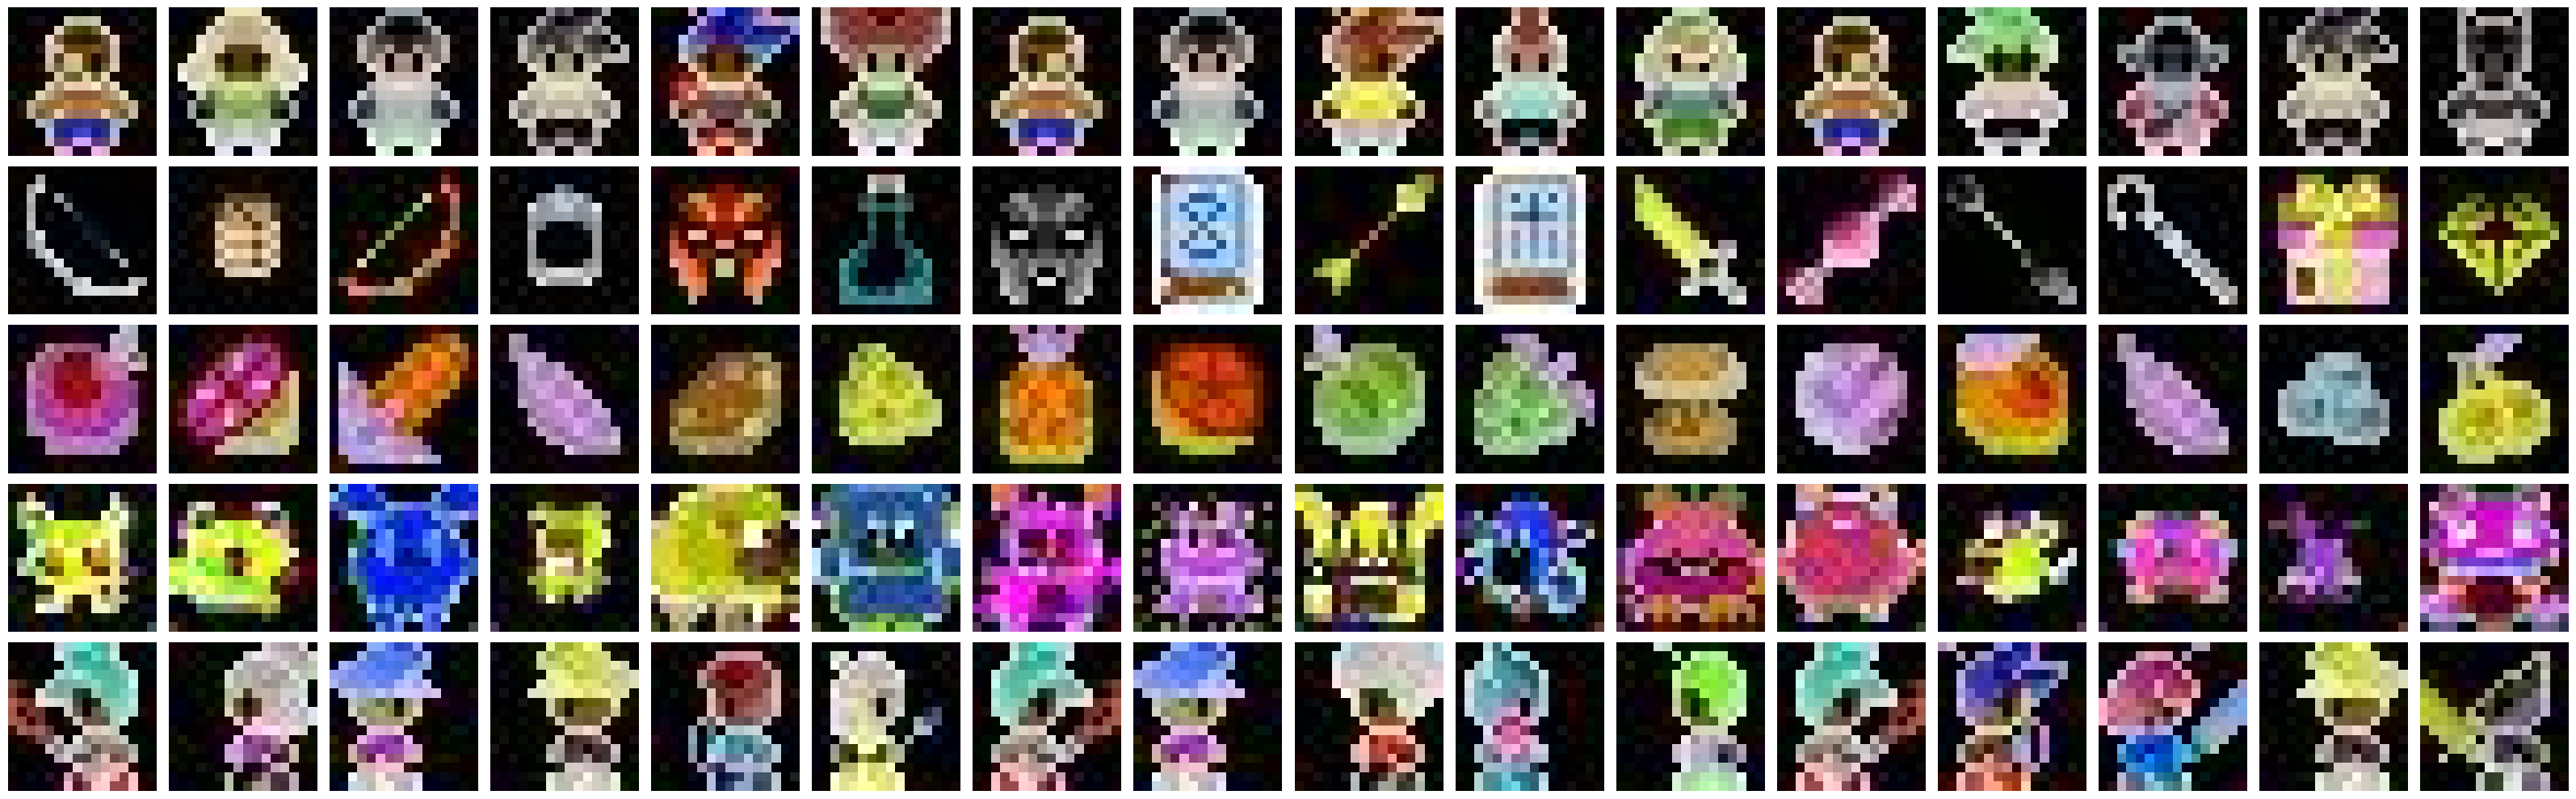

In [34]:
# --- Visualize a balanced per-class sample  ---
# pick top classes by frequency
top_classes = (
    df["class_idx"].value_counts()
    .sort_values(ascending=False)
    .index.tolist()
)

df_top = df[df["class_idx"].isin(top_classes)].copy()

# sample up to SAMPLES_PER_CLASS per class
per_class_samples = (
    df_top.groupby("class_idx", group_keys=False)
          .apply(lambda g: g.sample(min(SAMPLES_PER_CLASS, len(g)), random_state=RANDOM_STATE))
          .reset_index(drop=True)
)

print("showing classes:", [f"{c}={idx_to_class[c]}" for c in top_classes])

show_grid(
    per_class_samples["path"],
    cols=16,
    scale=2,
    swap_rb=True,            # set False if your images were NOT saved from OpenCV/BGR
    composite_on_white=True  # set False to preserve transparency on dark bg
)


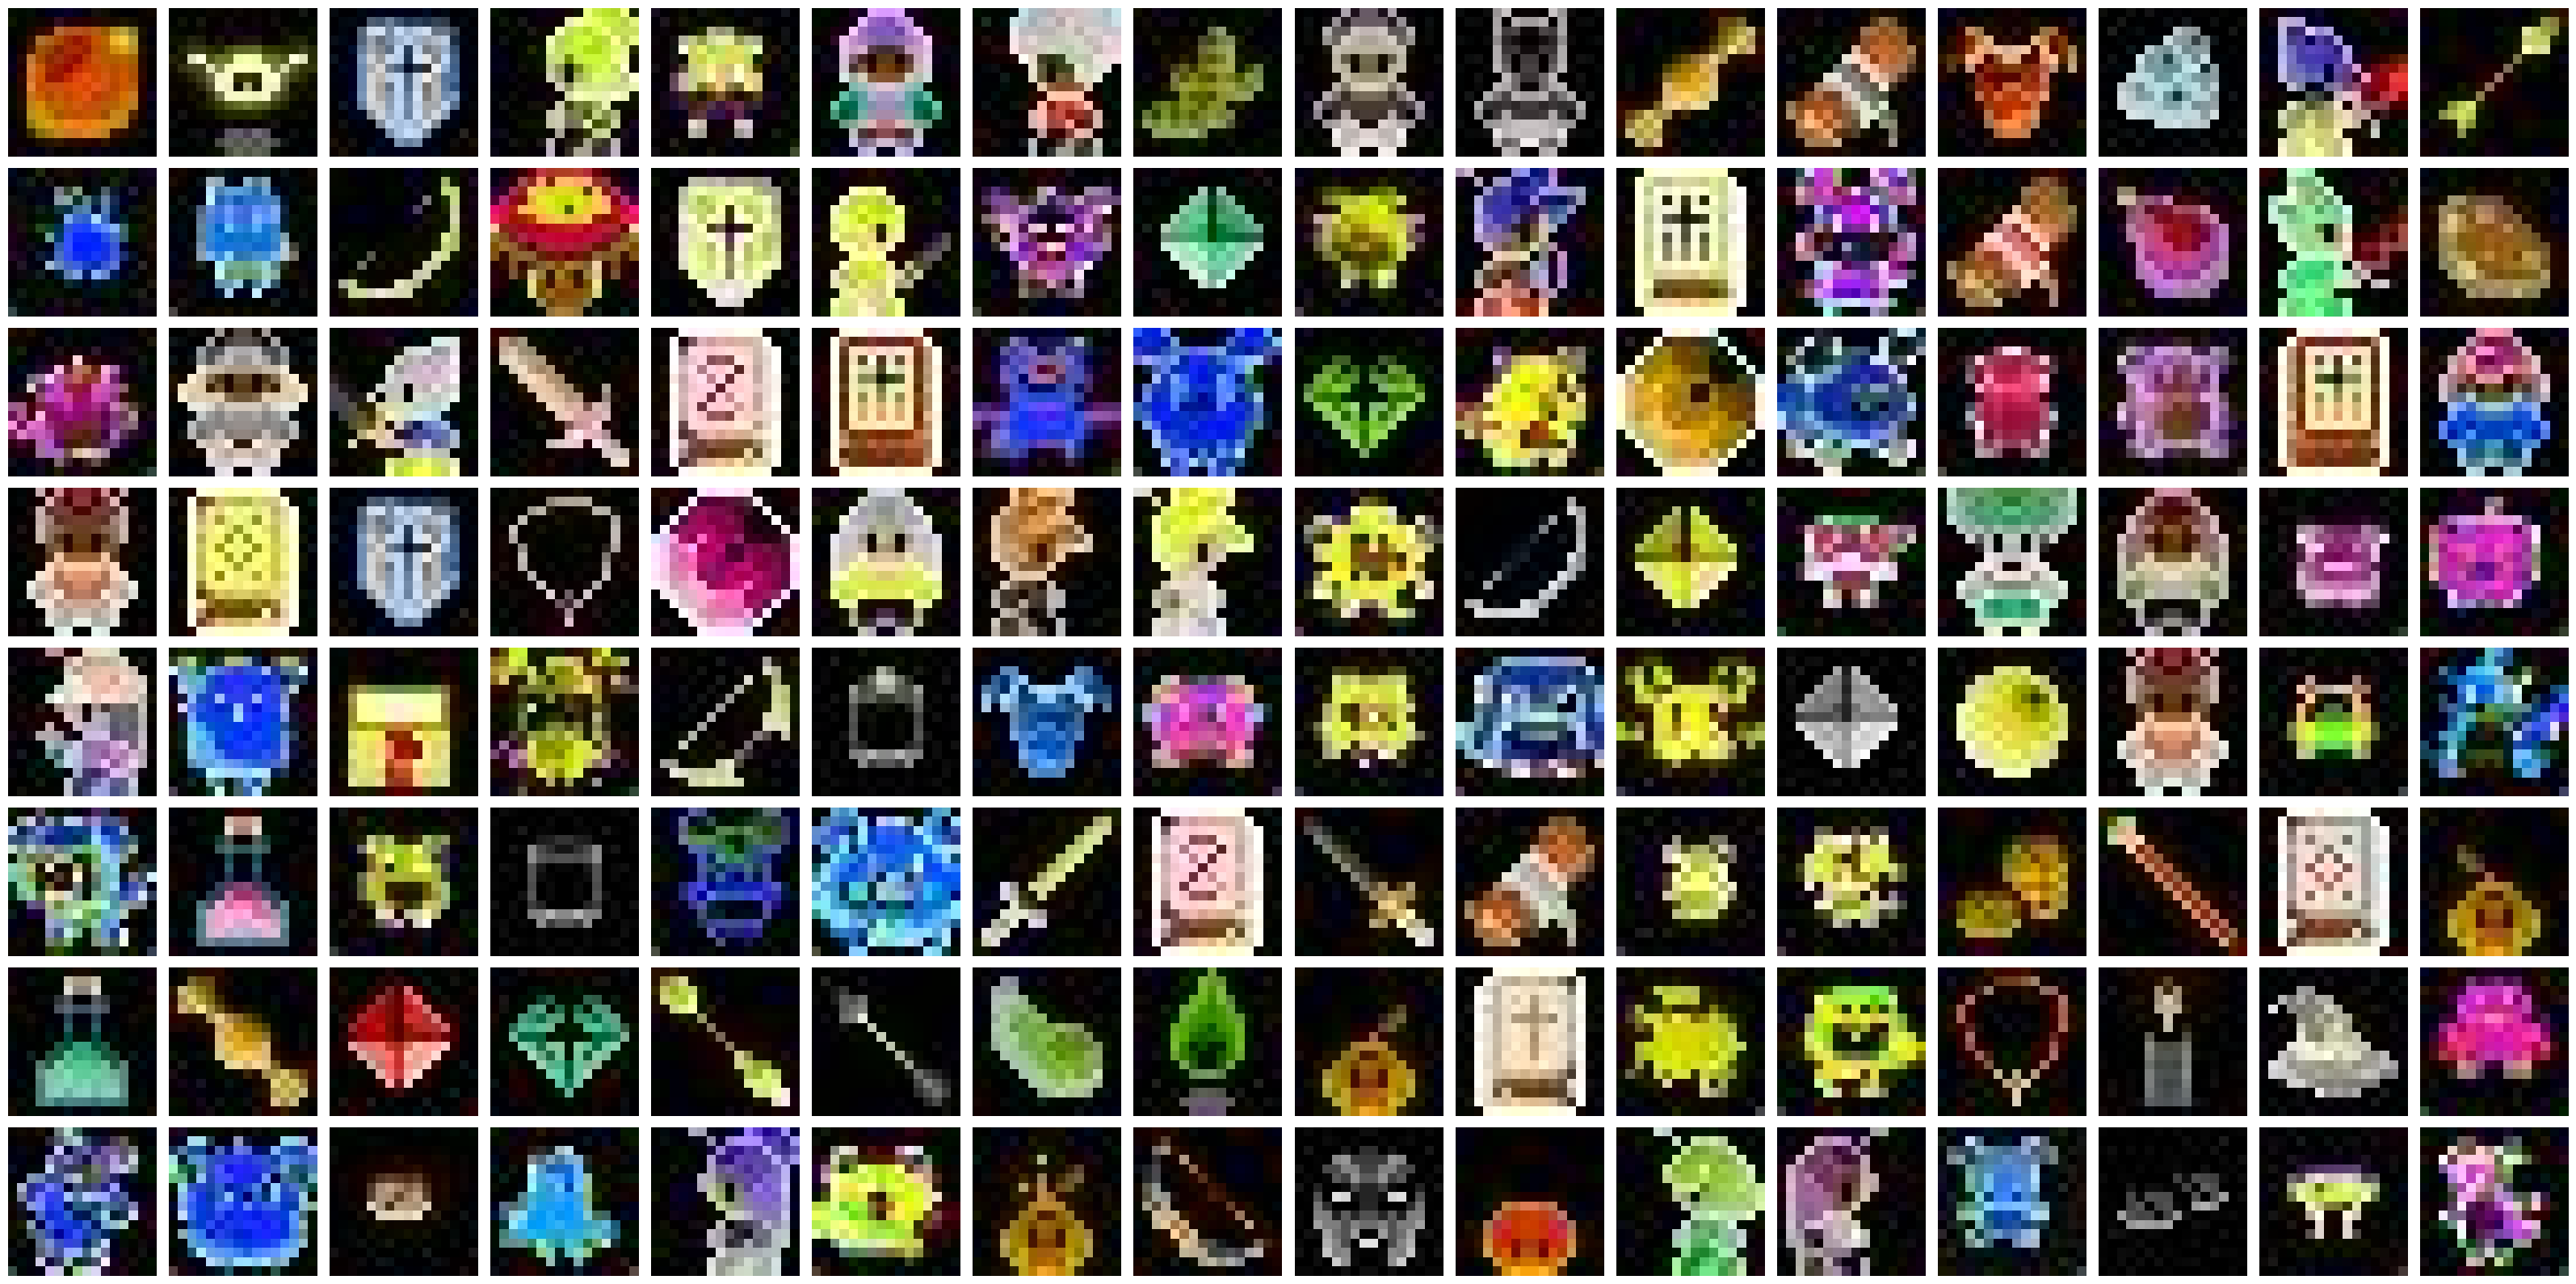

In [38]:
 # --- (Optional) Visualize a random sample regardless of class ---
 show_grid(
     df["path"].sample(min(128, len(df)), random_state=RANDOM_STATE),
     cols=16,
     scale=2,
     swap_rb=True,
     composite_on_white=True
 )
